In [1]:
import numpy as np
import h5py
import os, sys 
import pandas as pd 

from paramiko import SSHClient
from scp import SCPClient

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

### Download data from remote server

In [2]:
# set up local results directory
EXPT_DIRNAME = "deepbind_encode_chipseq"
RESULTSDIR = os.path.join(os.getcwd(), '..', 'results', EXPT_DIRNAME)  ## local path
if not os.path.exists(RESULTSDIR):
    os.makedirs(RESULTSDIR)

# set up remote paths and ssh clients 
username, hostname = os.getenv('BAMDEV1').split("@")
ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(hostname=hostname, username=username)
remotehome = ssh.exec_command("echo $HOME")[1].readlines()[0].strip()
scp = SCPClient(ssh.get_transport())
REMOTEDIR = os.path.join(remotehome, "projects/higher_order_convolutions_full/results", EXPT_DIRNAME)

In [3]:
# get all remote directories 
tfids = [l.strip() for l in ssh.exec_command("ls %s"%REMOTEDIR)[1].readlines()]
_remove = []
for tfid in tfids:
    if len(ssh.exec_command("find %s -name \"test_metrics.csv\""%os.path.join(REMOTEDIR, tfid))[1].readlines()) < 13:
        _remove.append(tfid)
tfids = [tfid for tfid in tfids if tfid not in _remove]
print(len(tfids))

108


In [4]:
download = True
if download:
    for tfid in tfids:
        print("Downloading results for TF : %s"%tfid)
        remote_tfid_dir = os.path.join(REMOTEDIR, tfid)
        local_tfid_dir = os.path.join(RESULTSDIR, tfid)
        conv_type_dirs = [l.strip() for l in ssh.exec_command("ls %s"%remote_tfid_dir)[1].readlines()]

        for conv_type in conv_type_dirs:
            conv_type_dir = os.path.join(remote_tfid_dir, conv_type)
            res = [l.strip() for l in ssh.exec_command("ls %s"%conv_type_dir)[1].readlines()]

            # check for standard conv
            if "test_metrics.csv" in res:
                remote_path = os.path.join(conv_type_dir, "test_metrics.csv")
                local_path = os.path.join(local_tfid_dir, conv_type)
                if not os.path.exists(local_path):
                    os.makedirs(local_path)
                if not os.path.exists(os.path.join(local_path, "test_metrics.csv")):
                    scp.get(remote_path=remote_path, local_path=local_path)

                remote_path = os.path.join(conv_type_dir, "history.csv")
                local_path = os.path.join(local_tfid_dir, conv_type)
                if not os.path.exists(os.path.join(local_path, "history.csv")):
                    scp.get(remote_path=remote_path, local_path=local_path)

            else:
                for l1_dir in res:
                    remote_path = os.path.join(conv_type_dir, l1_dir, "test_metrics.csv")
                    local_path = os.path.join(local_tfid_dir, conv_type, l1_dir)
                    if not os.path.exists(local_path):
                        os.makedirs(local_path)
                    if not os.path.exists(os.path.join(local_path, "test_metrics.csv")):
                        scp.get(remote_path=remote_path, local_path=local_path)

                    remote_path = os.path.join(conv_type_dir, l1_dir, "history.csv")
                    local_path = os.path.join(local_tfid_dir, conv_type, l1_dir)
                    if not os.path.exists(os.path.join(local_path, "history.csv")):
                        scp.get(remote_path=remote_path, local_path=local_path)

### Collect results from local 

In [5]:
reg_test_metrics_df = {'TFID':[],  'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}
pairwise_test_metrics_df = {'TFID':[], "l1":[], 'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}
nn_test_metrics_df = {'TFID':[], "l1":[], 'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}

for tfid in tfids:
    #print("Collecting results for TF : %s ..."%tfid)
    tfid_dir = os.path.join(RESULTSDIR, tfid)
    
    # get regular conv results 
    reg_test_metrics_df['TFID'].append(tfid)
    reg_dir = os.path.join(tfid_dir, "regular_conv_results")
    reg_path = os.path.join(reg_dir, "test_metrics.csv")
    df=pd.read_csv(reg_path, index_col=[0])
    names = df.Metric.values
    values = df.Value.values
    for name, value in zip(names, values):
        reg_test_metrics_df[name].append(value)
    # get pairwise conv results 
    pairwise_dir = os.path.join(tfid_dir, "pairwise_conv_results")
    for i, l1folder in enumerate(os.listdir(pairwise_dir)):
        pairwise_test_metrics_df['TFID'].append(tfid)
        pairwise_test_metrics_df['l1'].append(str(l1folder).split("=")[-1])
        fname = os.path.join(pairwise_dir, l1folder, "test_metrics.csv")
        df=pd.read_csv(fname, index_col=[0])
        names = df.Metric.values
        values = df.Value.values
        for name, value in zip(names, values):
            pairwise_test_metrics_df[name].append(value)
    
    # get nearest neighbor conv results 
    nn_dir = os.path.join(tfid_dir, "nearest_neighbor_conv_results")
    for i, l1folder in enumerate(os.listdir(nn_dir)):
        nn_test_metrics_df['TFID'].append(tfid)
        nn_test_metrics_df['l1'].append(str(l1folder).split("=")[-1])
        fname = os.path.join(nn_dir, l1folder, "test_metrics.csv")
        df=pd.read_csv(fname, index_col=[0])
        names = df.Metric.values
        values = df.Value.values
        for name, value in zip(names, values):
            nn_test_metrics_df[name].append(value)
    
    
    # get nearest neighbor conv results 
    tfid_nn_dir = os.path.join(tfid_dir, "nearest_neighbor_conv_results")

reg_test_metrics_df = pd.DataFrame(reg_test_metrics_df).sort_values(by='TFID')
pairwise_test_metrics_df = pd.DataFrame(pairwise_test_metrics_df).sort_values(by='TFID')
nn_test_metrics_df = pd.DataFrame(nn_test_metrics_df).sort_values(by='TFID')
highorder_conv_test_metrics = {'pairwise':pairwise_test_metrics_df, 'nearest neighbor':nn_test_metrics_df}
metric_names = list(reg_test_metrics_df.columns[-3:])

### plots for NN conv

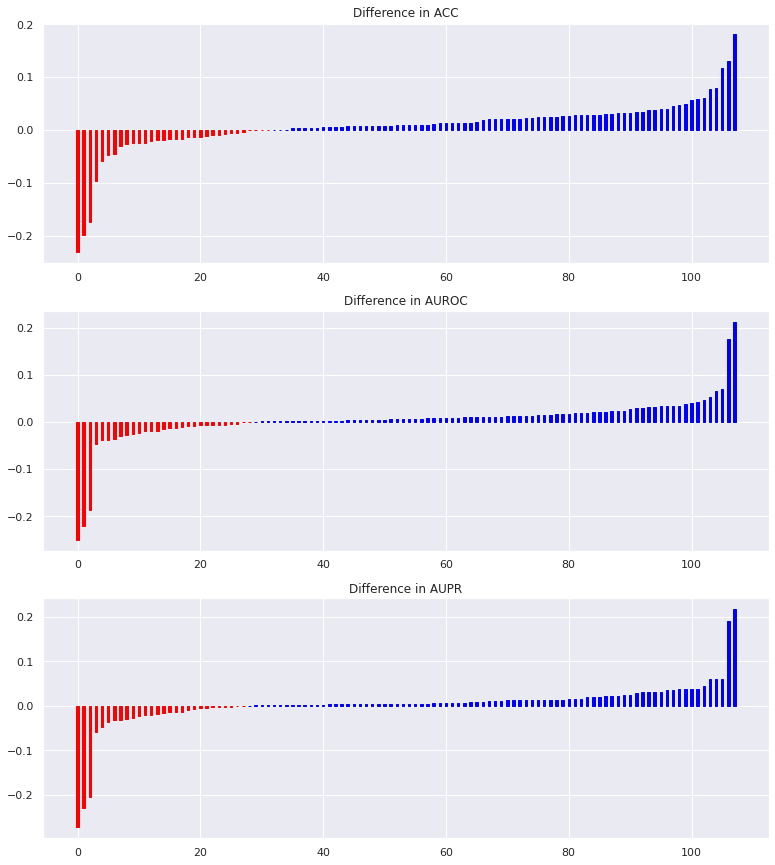

In [6]:
model_type = 'nearest neighbor'
test_metrics_df = highorder_conv_test_metrics[model_type]

plt.figure(figsize=(13, 15))
for j,metric_name in enumerate(metric_names):
    plt.subplot(3, 1, j+1)
    best_l1_factor_idx = test_metrics_df.groupby('TFID')[metric_name].idxmax().values
    best_l1_factor = test_metrics_df[['TFID','l1']].iloc[best_l1_factor_idx]
    best_metric = test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric['TFID'] = best_metric.index
    
    best_metric.index = np.arange(len(tfids))
    best_metric = best_metric.iloc[:, ::-1]
    
    best_metric = pd.merge(best_metric, best_l1_factor, on="TFID")
    reg_metric = reg_test_metrics_df[['TFID',metric_name]]
    assert np.all(best_metric.TFID.values==reg_metric.TFID.values) ## make sure comparing the right TF results 
    diff=(best_metric[metric_name]-reg_metric[metric_name]).values
    idx = np.argsort(diff)

    barlist = plt.bar(np.arange(len(diff)), 
            diff[idx], 
            width=0.4, edgecolor='none')
    plt.title("Difference in %s"%metric_name)
    for bar in barlist:
        if bar._height > 0:
            bar.set_color("blue")
        else:
            bar.set_color("red")

### plots for pairwise conv

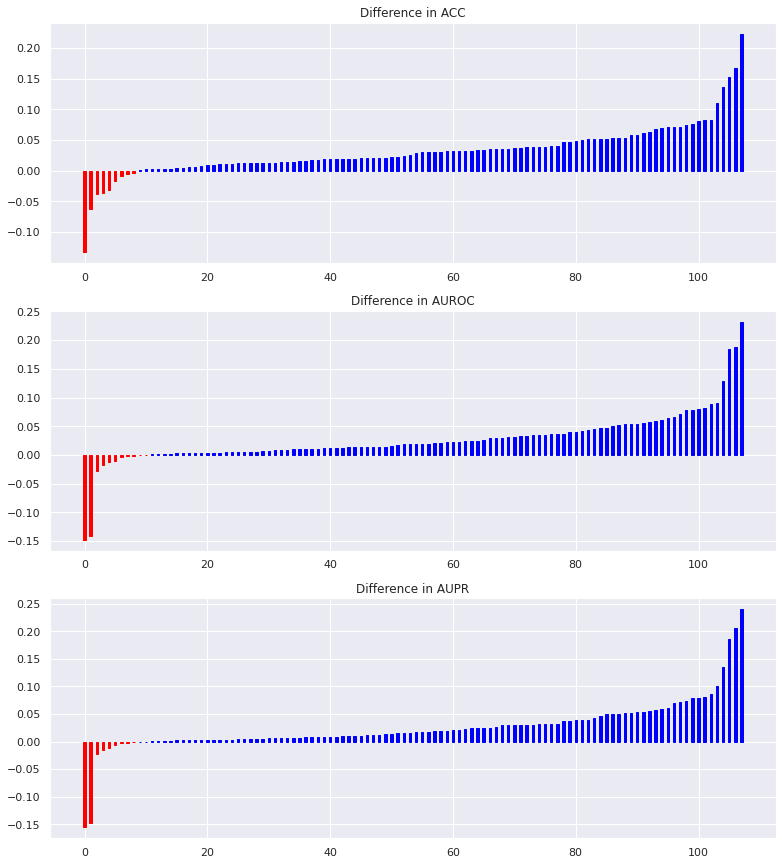

In [7]:
model_type = 'pairwise'
test_metrics_df = highorder_conv_test_metrics[model_type]

plt.figure(figsize=(13, 15))
for j,metric_name in enumerate(metric_names):
    plt.subplot(3, 1, j+1)
    best_l1_factor_idx = test_metrics_df.groupby('TFID')[metric_name].idxmax().values
    best_l1_factor = test_metrics_df[['TFID','l1']].iloc[best_l1_factor_idx]
    best_metric = test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric['TFID'] = best_metric.index
    best_metric.index = np.arange(len(tfids))
    best_metric = best_metric.iloc[:, ::-1]
    
    best_metric = pd.merge(best_metric, best_l1_factor, on="TFID")
    reg_metric = reg_test_metrics_df[['TFID',metric_name]]
    assert np.all(best_metric.TFID.values==reg_metric.TFID.values) ## make sure comparing the right TF results 
    diff=(best_metric[metric_name]-reg_metric[metric_name]).values
    idx = np.argsort(diff)

    barlist = plt.bar(np.arange(len(diff)), 
            diff[idx], 
            width=0.4, edgecolor='none')
    plt.title("Difference in %s"%metric_name)
    for bar in barlist:
        if bar._height > 0:
            bar.set_color("blue")
        else:
            bar.set_color("red")

### best pairwise vs best NN

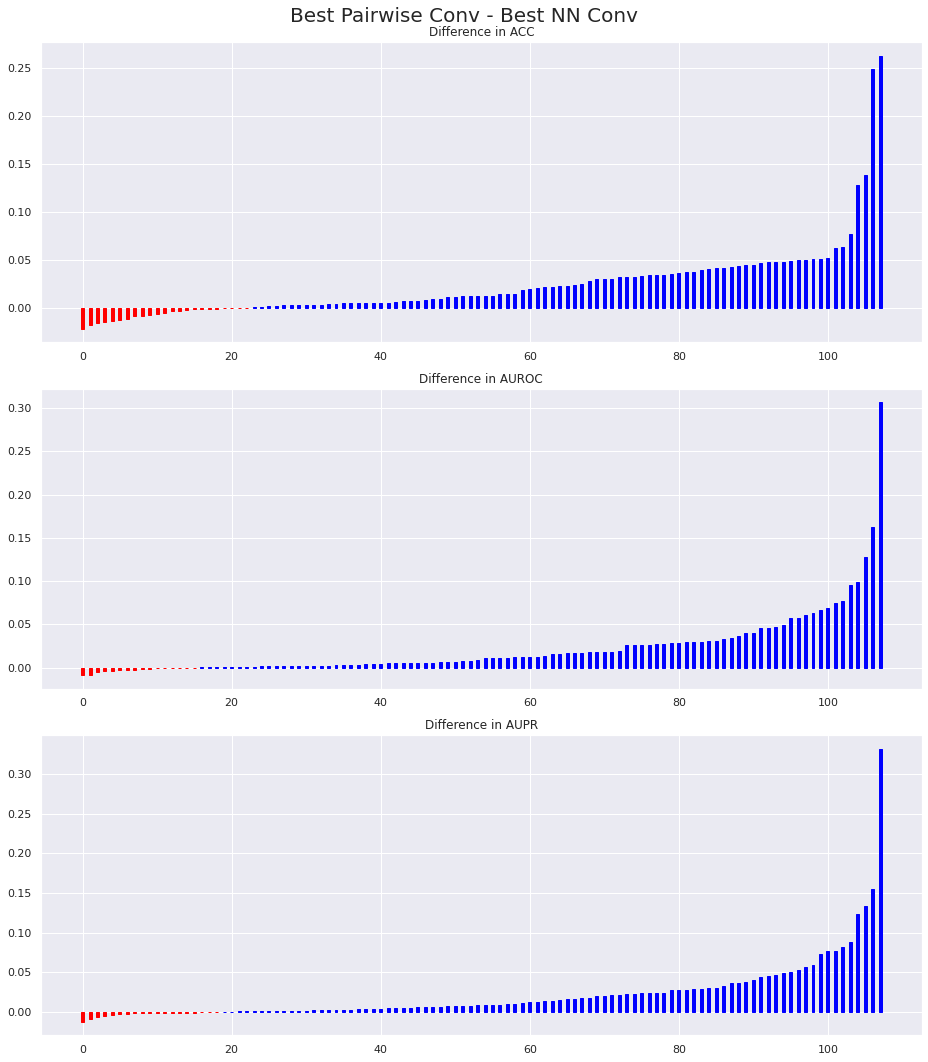

In [8]:
nn_test_metrics_df = highorder_conv_test_metrics['nearest neighbor']
pairwise_test_metrics_df = highorder_conv_test_metrics['pairwise']

plt.figure(figsize=(13, 15))
for j,metric_name in enumerate(metric_names):
    plt.subplot(3, 1, j+1)
    best_metric_nn = nn_test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric_nn['TFID'] = best_metric_nn.index
    best_metric_nn.index = np.arange(len(tfids))
    best_metric_nn = best_metric_nn.iloc[:, ::-1]
    
    best_metric_pairwise = pairwise_test_metrics_df.groupby('TFID').aggregate({metric_name:'max'})
    best_metric_pairwise['TFID'] = best_metric_pairwise.index
    best_metric_pairwise.index = np.arange(len(tfids))
    best_metric_pairwise = best_metric_pairwise.iloc[:, ::-1]
    
    best_metric = pd.merge(best_metric_nn, best_metric_pairwise, on='TFID')
    best_metric['diff'] = best_metric.iloc[:, 1] - best_metric.iloc[:, 2]
    diff = - best_metric['diff'].values
    idx = np.argsort(diff)

    barlist = plt.bar(np.arange(len(diff)), 
            diff[idx], 
            width=0.4, edgecolor='none')
    plt.title("Difference in %s"%metric_name)
    for bar in barlist:
        if bar._height > 0:
            bar.set_color("blue")
        else:
            bar.set_color("red")
plt.suptitle("Best Pairwise Conv - Best NN Conv", fontsize=20)
plt.tight_layout()

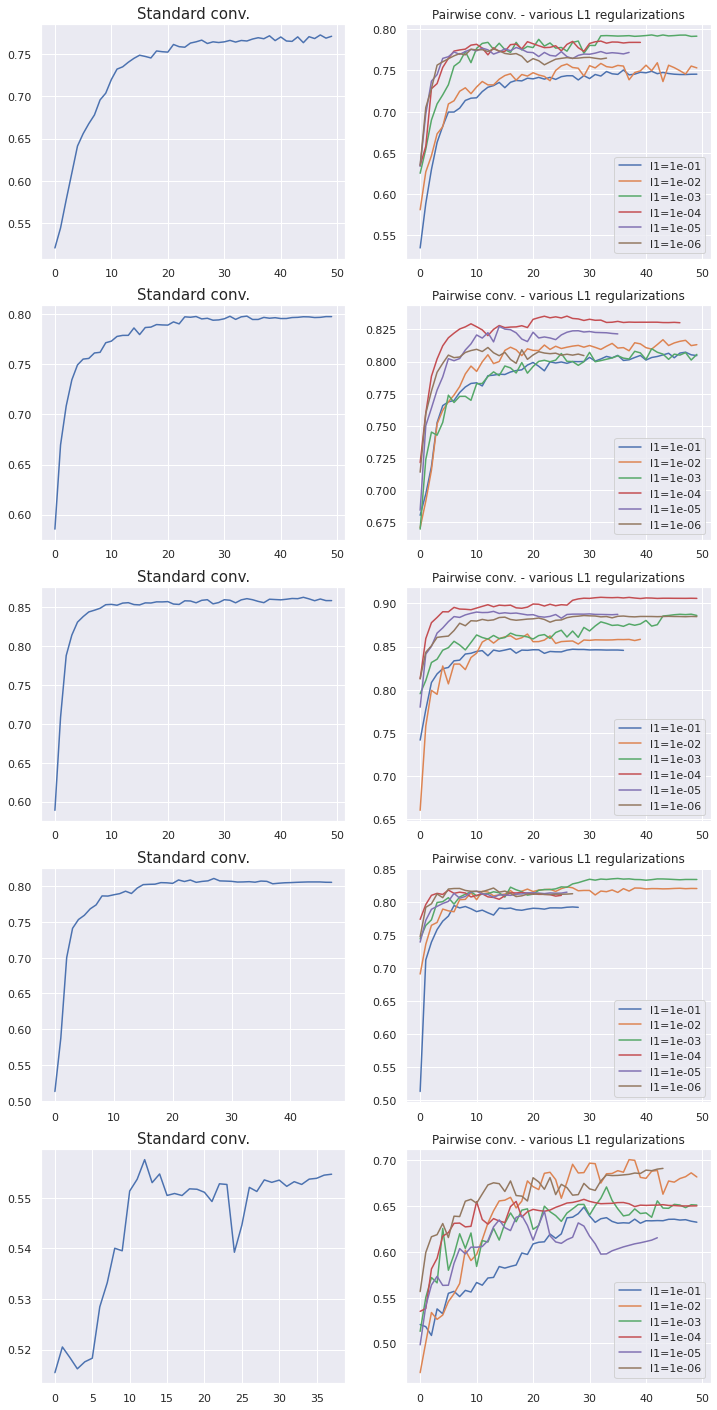

In [9]:
fig, Ax = plt.subplots(5, 2, figsize=(12, 25))
for i, tfid in enumerate(tfids):
    ax = Ax[i]
    
    regular_resultdir = os.path.join(RESULTSDIR, tfid, 'regular_conv_results')
    history_file_path = os.path.join(regular_resultdir, 'history.csv')
    history = pd.read_csv(history_file_path)
    ax[0].plot(history['val_AUROC'])
    #ax[0].plot(history['AUROC'])
    #ax[0].set_ylim(top=0.9)
    ax[0].set_title("Standard conv.", fontsize=15)
    
    pairwise_resultdir = os.path.join(RESULTSDIR, tfid, 'pairwise_conv_results')
    l1_factors = os.listdir(pairwise_resultdir)
    for l1_factor in l1_factors:
        history_file_path = os.path.join(pairwise_resultdir, l1_factor, 'history.csv')
        history = pd.read_csv(history_file_path)
        ax[1].plot(history['val_AUROC'], label=l1_factor)
        #ax[1].plot(history['AUROC'])
    #ax[1].set_ylim(top=0.9)
    ax[1].legend(loc='best')
    ax[1].set_title("Pairwise conv. - various L1 regularizations")
    
    if i == Ax.shape[0] - 1:
        break

In [20]:
from tensorflow import keras as tfk
from tensorflow import keras

## input layer and 1st convolution layer 
x = tfk.layers.Input((101, 4), name='Input')
y = tfk.layers.Conv1D(filters=32, kernel_size=19, padding='same', name='conv1', use_bias=True)(x)

# # remaining layers
y = keras.layers.Activation('relu')(y)
y = keras.layers.MaxPool1D(pool_size=20)(y)
embedding = keras.layers.Dropout(0.1)(y)
y, weights = tfk.layers.MultiHeadAttention(num_heads=8, key_dim=64, value_dim=64)(embedding, embedding, return_attention_scores=True)
y = keras.layers.Dropout(0.1)(y)
y = keras.layers.LayerNormalization(epsilon=1e-6)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(128, activation=None, use_bias=False)(y)
y = keras.layers.BatchNormalization()(y)
y = keras.layers.Activation('relu')(y)
y = keras.layers.Dropout(0.5)(y)
y = keras.layers.Dense(1, name='logits')(y)
y = keras.layers.Activation('sigmoid', name='output')(y)

# # assembled model
model = tfk.Model(inputs=x, outputs=y)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 101, 32)      2464        Input[0][0]                      
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 101, 32)      0           conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 5, 32)        0           activation_5[0][0]               
____________________________________________________________________________________________

In [23]:
import tensorflow as tf
x = tf.random.normal((1, 11, 1))
pool = tfk.layers.MaxPool1D(5, )
print(x)
print("\n")
print(pool(x))

tf.Tensor(
[[[-0.9581657 ]
  [ 1.616343  ]
  [-1.0677242 ]
  [ 1.8678902 ]
  [ 0.50205934]
  [ 1.3308678 ]
  [-0.4101438 ]
  [-1.2396957 ]
  [ 0.7036922 ]
  [ 0.30751032]
  [-0.7426175 ]]], shape=(1, 11, 1), dtype=float32)


tf.Tensor(
[[[1.8678902]
  [1.3308678]]], shape=(1, 2, 1), dtype=float32)
